## Runs logistic regression models

In [2]:
import pandas as pd
import numpy as np
import warnings; 
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')
#from sklearn.preprocessing import CategoricalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

## Creating Test/Train Sets

In [3]:
# FLAGS TO TOGGLE BETWEEN DIFFERENT MODELS
# flag_baseline: 
#   1 - absence of any spatial or temporal features (should be with flag_early = 1)
#   0 - all features

# flag_early: 
#   1 - early predictability. features a function of osc_date. 
#   0 - late predictability. features a function of last hearing.
# flag_spatialonly: baseline features + spatial features
# flag_temponly: baseline features + temporal features

# flags
flag_baseline = 0
flag_early = 0
flag_spatialonly = 0
flag_temponly = 0

# used for loading appropriate dataset file
if flag_early:
    tag_pred = 'early'
else:
    tag_pred = 'late'


In [4]:
# LOAD AND MERGE DATA FILES

# load
path = '/data/WorkData/spatialtemporal/'
file = pd.read_csv(path + 'finalmerge_any_'+ tag_pred + 'v2.csv')
timefile = pd.read_csv(path + 'gr_lastyear_' + tag_pred + '.csv')
test_cases = pd.read_csv(path + 'test_cases_last_hearing.csv', header=None)

# merge
if (not flag_baseline) and (not flag_spatialonly): file = pd.merge(file, timefile, on=['idnproceeding','idncase'], how='left')

In [5]:
file.dtypes

idncase                            float64
idnproceeding                      float64
dec                                float64
numAppsPerProc                       int64
nat                                 object
case_type                           object
c_asy_type                          object
base_city_code                      object
hearing_loc_code                    object
osc_date                            object
comp_date                           object
attorney_flag                      float64
tracid                             float64
hearing_city                        object
base_city                           object
numProcPerCase                       int64
adj_medium                          object
adj_date                            object
sched_type                          object
lang_hearing                        object
notice_desc                         object
adj_time_start2                     object
adj_time_stop2                      object
durationHea

In [6]:
# GET TRAINING DATASET

test_cases = test_cases.rename(columns={0:'num'})
train = file[~file.idncase.isin(test_cases.num)]

In [7]:
# DEFINE CLEANING SCRIPT AND FEATURE NAMES
# this file removes any irrelevant features from dataset

if flag_early: # early predictability
    cols = ['idncase', 'idnproceeding','adj_date','comp_date','osc_date','base_city_code',
            'notice_desc','adj_time_start2','adj_time_stop2','durationHearing',
            'numAppsPerProc','numProcPerCase','osc_date','adj_rsn_desc']
else: # late predictability
    #note: temporary fix by dropping duration hearing and averageHearingDur, which have NaNs. change later!
    cols = ['idncase', 'idnproceeding','adj_date','comp_date','osc_date','numAppsPerProc','numProcPerCase','base_city_code',
            'notice_desc','adj_time_start2','adj_time_stop2','adj_rsn_desc']

if flag_spatialonly: # spatial features only
    if flag_early: cols2 = ['osc_date_delta','pres_aff','hearingYear','hearingMonth','hearingDayOfWeek']
    else: cols2 = ['osc_date_delta','pres_aff','hearingYear','hearingMonth','hearingDayOfWeek',
                  'numHearingsPerProc','durationFirstLastHearing','caseDuration']
    
if flag_temponly: # temporal features only
    cols2 = ['hearing_loc_code','base_city','hearing_city']

if flag_baseline: # baseline model only
    cols = ['dec','tracid','nat','c_asy_type','case_type','lang_hearing',
            'attorney_flag','sched_type','adj_medium'] # dropping spatial and temporal variables
    #'numAppsPerProc','numProcPerCase','osc_date_delta'
    

class Cleaning(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        
        # drop unused columns
        if flag_baseline: X = X[cols]
        else: X = X.drop(columns=cols)
        
        if flag_spatialonly: X = X.drop(columns=cols2)
        if flag_temponly: X = X.drop(columns=cols2)
            
        # make variables correct dtypes
        X['tracid'] = X['tracid'].astype('str')
        X['adj_medium'] = X['adj_medium'].astype('str')
        X['sched_type'] = X['sched_type'].astype('str')
        X['nat'] = X['nat'].astype('str')
        X['case_type'] = X['case_type'].astype('str')
        X['c_asy_type'] = X['c_asy_type'].astype('str')
        X['lang_hearing'] = X['lang_hearing'].astype('str')

        if (not flag_baseline): 
            if not flag_temponly:
                X['hearing_loc_code'] = X['hearing_loc_code'].astype('str')
                X['hearing_city'] = X['hearing_city'].astype('str')
                X['base_city'] = X['base_city'].astype('str')
            if not flag_spatialonly:
                X['hearingMonth'] = X['hearingMonth'].astype('str')
                X['hearingDayOfWeek'] = X['hearingDayOfWeek'].astype('str')    
                X['hearingYear'] = X['hearingYear'].astype('float64')
                X['pres_aff'] = X['pres_aff'].astype('str')
            #if not flag_early:
                #train_data['hearingMonth'] = train_data['hearingMonth'].astype('str')

        return X
    

In [8]:
# RUNNING CLEANING SCRIPT

clean = Cleaning()
train_data = clean.transform(train)

In [9]:
# MAKE VARIABLES CORRECT DTYPES

train_data['tracid'] = train_data['tracid'].astype('str')
train_data['adj_medium'] = train_data['adj_medium'].astype('str')
train_data['sched_type'] = train_data['sched_type'].astype('str')
train_data['nat'] = train_data['nat'].astype('str')
train_data['case_type'] = train_data['case_type'].astype('str')
train_data['c_asy_type'] = train_data['c_asy_type'].astype('str')
train_data['lang_hearing'] = train_data['lang_hearing'].astype('str')

if (not flag_baseline): 
    if not flag_temponly:
        train_data['hearing_loc_code'] = train_data['hearing_loc_code'].astype('str')
        train_data['hearing_city'] = train_data['hearing_city'].astype('str')
        train_data['base_city'] = train_data['base_city'].astype('str')
    if not flag_spatialonly:
        train_data['hearingMonth'] = train_data['hearingMonth'].astype('str')
        train_data['hearingDayOfWeek'] = train_data['hearingDayOfWeek'].astype('str')    
        train_data['hearingYear'] = train_data['hearingYear'].astype('float64')
        train_data['pres_aff'] = train_data['pres_aff'].astype('str')
    #if not flag_early:
        #train_data['hearingMonth'] = train_data['hearingMonth'].astype('str')
    
    

In [10]:
# last minute inspection of features and dtypes to make sure they are correct
train_data.dtypes

dec                                float64
nat                                 object
case_type                           object
c_asy_type                          object
hearing_loc_code                    object
attorney_flag                      float64
tracid                              object
hearing_city                        object
base_city                           object
adj_medium                          object
sched_type                          object
lang_hearing                        object
durationHearing                    float64
numHearingsPerProc                   int64
durationFirstLastHearing             int64
averageHearingDur                  float64
pres_aff                            object
osc_date_delta                       int64
caseDuration                         int64
hearingDayOfWeek                    object
hearingYear                        float64
hearingMonth                        object
nat_num_last1yr_late               float64
nat_gr_last

In [11]:
#these showed that these two columns have nans for late
#np.any(np.isnan(X_train.averageHearingDur))
#np.any(np.isnan(X_train.durationHearing))


In [12]:
# make input and output variables
y_train = train_data['dec']
X_train = train_data.drop(columns=['dec'], axis=1)

## Generating Pipeline

In [13]:
class Selector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        num_frame = X.select_dtypes(include=[self.dtype])
        self.names = num_frame.columns
        return num_frame
    def get_feature_names(self):
        return self.names.tolist()

In [14]:
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        #X = np.asarray(pd.get_dummies(X))
        #self.names = X.columns 
        self.names = np.array(0)
        self.orig_classes = np.array(0)
        for col in X.columns:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
            #cat_frame = X.apply(le.fit_transform)
            self.names = np.append(self.names, le.classes_)
            c_list = np.array(0)
            for f in le.classes_:
                c_list = np.append(c_list,col)
            c_list = c_list[1:]
            self.orig_classes = np.append(self.orig_classes, c_list)
        self.names = self.names[1:]
        self.orig_classes =  self.orig_classes[1:]
    
        return X
    def get_feature_names(self):
        return self.names.tolist()
    def get_orig_classes(self): 
        # returns original variable type of the feature, i.e. nat
        return self.orig_classes.tolist()

In [15]:
# CODE FOR PUTTING FEATURES IN CORRECT FORMAT FOR EACH MODEL

# shift and scale numerical data
num_pipeline = Pipeline([
        ('selector', Selector(np.number)),
        ('scaler', StandardScaler()),
])


# one hot encoding categorical features for regression
cat_pipeline_reg = Pipeline([
        ('selector', Selector('object')),
        ('labeler', CustomLabelEncoder()),
        ('encoder', OneHotEncoder())
]) 


# feature pipeline for regression
full_pipeline_reg = FeatureUnion(transformer_list=[ 
        ('numerical', num_pipeline),  
        ('categorical', cat_pipeline_reg)   
])  

## Pipeline-for regression models
### (categorical variables one hot encoded)

In [16]:
# training data for regression
X_train_tr_reg = full_pipeline_reg.fit_transform(X_train)

In [17]:
num_features = num_pipeline.named_steps['selector'].get_feature_names()
cat_features = cat_pipeline_reg.named_steps['labeler'].get_feature_names()
cat_classes = cat_pipeline_reg.named_steps['labeler'].get_orig_classes()
num_features

['attorney_flag',
 'durationHearing',
 'numHearingsPerProc',
 'durationFirstLastHearing',
 'averageHearingDur',
 'osc_date_delta',
 'caseDuration',
 'hearingYear',
 'nat_num_last1yr_late',
 'nat_gr_last1yr_late',
 'nat_dmy_last1yr_late',
 'tracid_num_last1yr_late',
 'tracid_gr_last1yr_late',
 'tracid_dmy_last1yr_late',
 'base_city_code_num_last1yr_late',
 'base_city_code_gr_last1yr_late',
 'base_city_code_dmy_last1yr_late',
 'tracid_gr_last10d',
 'tracid_dmy_last10d']

## Hyperparameter Grid Search On Logistic Regression

In [19]:
# HYPERPARAMETERS (differences in regularization parameter because of different number of features per model)
c_vec = 10**np.arange(-10,2).astype('float64')

param_grid = {'penalty': ['l1','l2'], 'C': c_vec}

In [20]:
# FIT MODEL AND PRINT RESULTS

log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X_train_tr_reg, y_train)
result = pd.DataFrame(grid_search.cv_results_)
print(result)

    mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
0        1.297078         0.035957         0.500000          0.500000   1e-10   
1        1.191061         0.051065         0.853424          0.797679   1e-10   
2        1.449831         0.037808         0.500000          0.500000   1e-09   
3        1.343026         0.048498         0.853426          0.797692   1e-09   
4        1.307283         0.037306         0.500000          0.500000   1e-08   
5        1.302289         0.052454         0.853439          0.797807   1e-08   
6        1.254023         0.039306         0.500000          0.500000   1e-07   
7        1.403329         0.048199         0.853573          0.798942   1e-07   
8        1.294865         0.032312         0.500000          0.500000   1e-06   
9        1.644993         0.055062         0.854421          0.808363   1e-06   
10       1.315910         0.037017         0.500000          0.500000   1e-05   
11       2.295481         0.

In [24]:
final_model = grid_search.best_estimator_
feature_weight = np.abs(grid_search.best_estimator_.coef_[0])


array([0.15924591, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

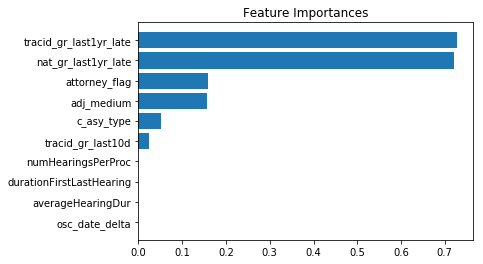

In [30]:
# PLOT FEATURE IMPORTANCE (summed absolute weights)--just top 10

# simplify feature weights--sum together all weights for a given category (all nationalities)
num_features = num_pipeline.named_steps['selector'].get_feature_names()
cat_features = cat_pipeline_reg.named_steps['labeler'].get_feature_names()
cat_classes = cat_pipeline_reg.named_steps['labeler'].get_orig_classes()
attributes = np.append(num_features,pd.unique(cat_classes)) 
attributes_long = num_features + cat_classes #for each of >1000 feature, lists original feature name, i.e. nat or tracid
feature_weight_simple = np.zeros(len(attributes))
for i in range(len(attributes)):
    weights = feature_weight[[x == attributes[i] for x in attributes_long]]
    feature_weight_simple[i] = np.sum(weights)
    
indices = np.argsort(feature_weight_simple)
plt.title('Feature Importances')
plt.barh(range(len(indices[-10:])), feature_weight_simple[indices[-10:]], align='center')
plt.yticks(range(len(indices[-10:])), [attributes[i] for i in indices[-10:]])
plt.savefig(path + tag_pred + 'logreg_feature_importance.png')